# This is for going over our DOS calculation 

In [1]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
import numpy as np
from scipy.constants import c
import matplotlib.pyplot as plt
import legume
legume.set_backend('autograd')
import autograd.numpy as npa
import optomization
import json
from optomization.utils import NG
import matplotlib as mpl

# Disable LaTeX but use Computer Modern fonts
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern math fonts
mpl.rcParams['font.family'] = 'STIXGeneral'  # Use STIX fonts (similar to Computer Modern)

Lets first get a standard W1 GME calculation

In [5]:
#set up some constants that we will use throughout this notebook 
ks = npa.linspace(npa.pi*.5,npa.pi,3)
Nx = 50
Ny = 50
Nz = 10
a = 240
gmax = 6.01 #slowly convergent as most field things are. look like less than 20% off at this point
gmode_inds = [0]
dslab = 150/a
eps_slab = np.sqrt(12.11)
ra = 70.8/a

#lets quickly simulate GME at the point of interest 
gmeParams = {'verbose':True,'numeig':21,'compute_im':False,'gmode_inds':gmode_inds,'kpoints':npa.array([ks,npa.zeros_like(ks)])}

In [6]:
phc = optomization.W1(NyChange=0,Ny=7)
gme = legume.GuidedModeExp(phc,gmax)
gme.run(**gmeParams)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 1357 plane waves and 1 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'         │ 0.620    │ │--------------------│    1% │
│ Inverse matrix of Fourier-space permittivity                │ 1.555    │ │--------------------│    2% │
│ Matrix diagionalization using the 'eigh' solver             │ 60.261   │ │██████████████████--│   94% │
│ Creating GME matrix                                         │ 1.850    │ │--------------------│    3% │
├─────────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 3 k-points      │ 64.317   │ │████████████████████│  100% │
└─────────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

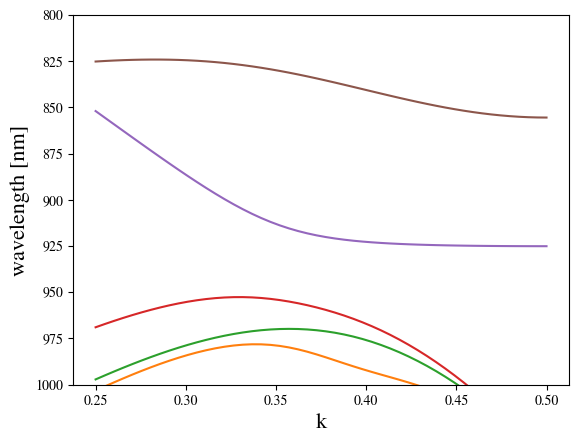

In [ ]:
plt.plot(ks/2/np.pi,a/gme.freqs)
plt.ylim(1000,800)
plt.xlabel('k',fontsize=16)
plt.ylabel('wavelength [nm]',fontsize=16)
plt.show()

To get the DOS, we need the imaginary component of our greens fucntion. The can be calculated with $$G(r,r;\omega)=\frac{ian_g\omega}{2c}[e_k(r)\cdot e^*_k(r)]$$ Where $e$ are the bloch modes. 

In [79]:
def greens(gme,k,n,ng,Nx=50,Ny=100,Nz=10,a=266):
    """
    Calculate the greens function for a given k-point and mode index across the 3D space
    """
    
    zs = np.linspace(0,gme.phc.layers[0].d,Nz,endpoint=True)
    g = npa.zeros((Nx,Ny,Nz),dtype=npa.complex128)
    for i,z in enumerate(zs):
        E,_,_ = gme.get_field_xy('E',k,n,z,Nx=Nx,Ny=Ny)
        field = npa.abs(E['x']*npa.conj(E['x'])+E['y']*npa.conj(E['y'])+E['z']*npa.conj(E['z'])).T
        g[:,:,i] = 1j*a*1E-9*ng*gme.freqs[k,n]*(field*c/a/1E-9)/2/c
    return g

greenFunctions = []
for k in range(len(ks)):
    greenFunctions.append(greens(gme,k,14,ngs[k],Nx=Nx,Ny=Ny,Nz=Nz,a=a))


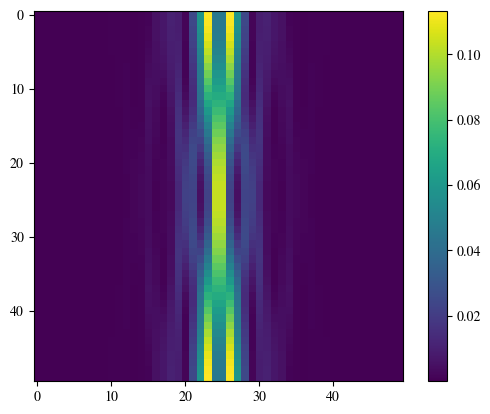

In [80]:
plt.imshow(np.imag(greenFunctions[24][:,:,5]))
plt.colorbar()
plt.show()

Now we have the Greens function for all of the points along the band of interest. Next we want to calculate the DOS. This can be done by taking the imaginary part of the greens function and integraing it $$\rho(\omega)=\int_{V}Im[G(r,r;\omega)]dr$$ Where $V$ is the volume of a unit cell. 

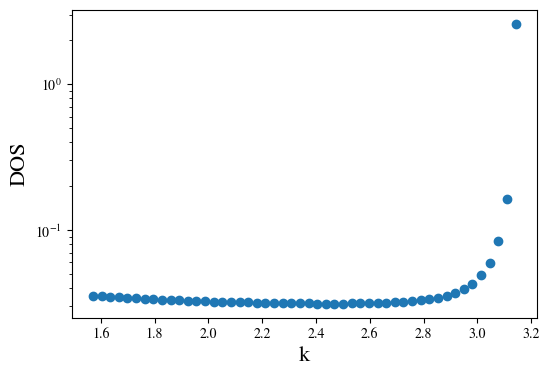

In [81]:
def DOS(greenFunctions,k,Nx=50,Ny=100,Nz=10,a=266):
    """
    Calculate the density of states for a given k-point on the band that the greens functions are calculated on
    """
    dos = npa.sum(npa.imag(greenFunctions[k]))*1/Nx/Ny/Nz*phc.lattice.a2[1]*phc.layers[0].d
    return dos


dos = []
for i in range(len(ks)):
    dos.append(DOS(greenFunctions,i))
fig,ax = plt.subplots(figsize=(6,4))
plt.plot(ks,dos,'o')
plt.yscale('log')
plt.xlabel('k',fontsize=16)
plt.ylabel('DOS',fontsize=16)
plt.show()

## Convergance tests

In [82]:
def dos_run(phc,Nx=50,Ny=100,Nz=10,gmax=4.01,gmode_inds=[0],a=266,ks=np.linspace(.5*np.pi,np.pi,5),truncate_g="abs"):
    """
    Full run of the DOS calculation
    """
    gme = legume.GuidedModeExp(phc,gmax,truncate_g=truncate_g)
    gme.run(gmode_inds=gmode_inds,numeig=21,compute_im=False,verbose=False,kpoints=np.vstack((ks,[0]*len(ks))))
    ngs = []
    for i in range(len(ks)):
        ngs.append(npa.abs(NG(gme,i,0)))
    greenFunctions = []
    for k in range(len(ks)):
        greenFunctions.append(greens(gme,k,14,ngs[k],Nx=Nx,Ny=Ny,Nz=Nz,a=a))

    dos = []
    for i in range(len(ks)):
        dos.append(DOS(greenFunctions,i,Nx=Nx,Ny=Ny,Nz=Nz,a=a))
    
    return dos



In [83]:
xs = np.linspace(50,300,4,dtype=int)
ys = np.linspace(50,300,4,dtype=int)
zs = np.linspace(5,20,4,dtype=int)

dosx = []
for x in xs:
    dosx.append(dos_run(phc,Nx=x,Ny=100,Nz=10,gmax=2.01,gmode_inds=[0],a=266,ks=np.linspace(.5*np.pi,np.pi,5)))

dosy = []
for y in ys:
    dosy.append(dos_run(phc,Nx=100,Ny=y,Nz=10,gmax=2.01,gmode_inds=[0],a=266,ks=np.linspace(.5*np.pi,np.pi,5)))

dosz = []
for z in zs:
    dosz.append(dos_run(phc,Nx=100,Ny=100,Nz=z,gmax=2.01,gmode_inds=[0],a=266,ks=np.linspace(.5*np.pi,np.pi,5)))

KeyboardInterrupt: 

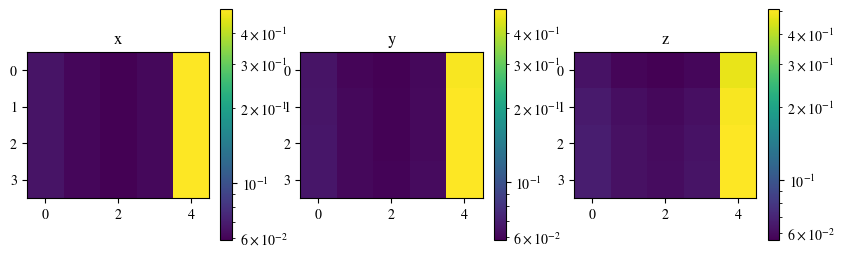

In [10]:
dosx = np.array(dosx)
dosy = np.array(dosy)
dosz = np.array(dosz)
fix, ax = plt.subplots(1, 3, figsize=(10, 3))
im0 = ax[0].imshow(dosx,norm=plt.matplotlib.colors.LogNorm())
im1 = ax[1].imshow(dosy,norm=plt.matplotlib.colors.LogNorm())
im2 = ax[2].imshow(dosz,norm=plt.matplotlib.colors.LogNorm())
fix.colorbar(im0, ax=ax[0])
fix.colorbar(im1, ax=ax[1])
fix.colorbar(im2, ax=ax[2])
ax[0].set_title('x')
ax[1].set_title('y')
ax[2].set_title('z')
plt.show()

In [11]:
gmaxs = np.linspace(2.01,6.01,5,endpoint=True)
gmode_indss = [[0],[0,2],[0,2,4],[0,2,4,6]]

dosgmaxs = []
for gmax in gmaxs:
    dosgmaxs.append(dos_run(phc,Nx=50,Ny=50,Nz=10,gmax=gmax,gmode_inds=[0],a=266,ks=np.linspace(.5*np.pi,np.pi,5)))

dosgmode_indss = []
for gmode_inds in gmode_indss:
    dosgmode_indss.append(dos_run(phc,Nx=50,Ny=50,Nz=10,gmax=4.01,gmode_inds=gmode_inds,a=266,ks=np.linspace(.5*np.pi,np.pi,5)))

dosgmaxs = np.array(dosgmaxs)
dosgmode_indss = np.array(dosgmode_indss)

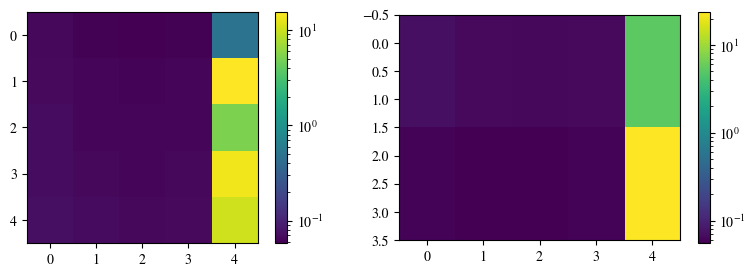

In [12]:
fix, ax = plt.subplots(1, 2, figsize=(10, 3))
im0 = ax[0].imshow(dosgmaxs,norm=plt.matplotlib.colors.LogNorm())
im1 = ax[1].imshow(dosgmode_indss,norm=plt.matplotlib.colors.LogNorm())
fix.colorbar(im0, ax=ax[0])
fix.colorbar(im1, ax=ax[1])
plt.show()

# Frequency Shift

The convergance is pretty quick in everything except gmax, so we are going to move on. We want to compare calculate the frequency shift due to disorder so that we can use it in our disordered DOS calculation. To do this we are going to use the following two formulas $$\mathbb E[\Delta\omega]=-\frac{\omega_0}{2}\int_V\mathbb E[E^*(r)\cdot P(r)]dr$$ and $$\mathbb E[\Delta\omega^2]=-\frac{\omega_0^2}{4}\int\int\mathbb E[E^*(r)\cdot P(r)E^*(r')\cdot P(r')]drdr'$$ and $$\sigma^2=\mathbb E[\Delta\omega^2]-(\mathbb E[\Delta \omega])^2$$ where $P$ represents the polorization model we are using.

Inorder to get a mean frequency shift we must use the bump purturbation model shown below.  $$P(r)=\left[\varepsilon_{avg}\alpha_{||}E_{||}(r)+\varepsilon(r)\gamma_{\perp}D_{\perp}(r))\right]\Delta V\delta(r-r')$$ where $\varepsilon_{avg}=\frac{\varepsilon_1+\varepsilon_2}{2}$ and $\alpha_{||}$ and $\gamma_\perp$ are the polarizabilities. In general the polorization function can have a large effect on the results, need to think about this more.

Inorder to calculate the bump perturbation model we use the following formula for the polorizabilities $$\alpha(\tau)=\frac{2(\tau-1)}{\tau+1}\left[1+\frac{\tau-1}{\frac{\tau}{\alpha_\infty/2-1}-\frac{1}{\alpha_0/2-1}}\right]$$ and $$\gamma(\tau)=\frac{\tau-1}{\tau}\left[1+\frac{\tau-1}{\frac{\tau}{\alpha'_\infty/2-1}-\frac{1}{\alpha'_0/2-1}}\right]$$ where $\alpha_\infty$ and $\alpha_0$ are fit parameters and $\tau=\frac{\varepsilon_1}{\varepsilon_2}$ where $\varepsilon_1$ is the material being extruded.

We will use the fit parameters for cylindrical bumbs here since we are benchmarking against the hole translations. These are symmetrical so that they are diagonal and the symmetries are such that they are the same in x and y. Therefor we get  
| Parameter | Value (xx and yy) |
|---------|-----|
| $\alpha_\infty$   | 0.8510  |
| $\alpha_0$        | 3.882   |
| $\alpha'_\infty$  | 3.905   |
| $\alpha'_0$       | 0.7669  |



First we need to get the field around the edges of the holes

In [7]:
def hole_borders(phc,phidiv=45):
    """
    returns the points at the hole borders
    """

    #get relevent information for computation
    shapes = phc.layers[0].shapes
    phis = npa.linspace(0,2*npa.pi,phidiv,endpoint=False)
    cphis = np.cos(phis); sphis = np.sin(phis)

    #get the array of hole atributes [xpos,ypos,r]
    holeCords = np.array([[s.x_cent, s.y_cent, s.r] for s in shapes])

    #get the coordinates of the hole borders
    # Compute the initial borders using broadcasting
    x_coords = holeCords[:, 0:1] + holeCords[:, 2:3] * cphis  # Add dimensions for broadcasting
    y_coords = holeCords[:, 1:2] + holeCords[:, 2:3] * sphis

    # Combine x and y coordinates
    initialBorders = np.stack([x_coords, y_coords], axis=-1)

    # Apply lattice corrections
    xCorrected = np.where(initialBorders[..., 0] > phc.lattice.a1[0] / 2, 
                         initialBorders[..., 0] - phc.lattice.a1[0], 
                         initialBorders[..., 0])
    yCorrected = np.where(initialBorders[..., 1] > phc.lattice.a2[0] / 2, 
                         initialBorders[..., 1] - phc.lattice.a2[0], 
                         initialBorders[..., 1])

    # Combine corrected coordinates
    borders = np.stack([xCorrected, yCorrected], axis=-1)

    return(borders, phis, holeCords[:,2])
    
def get_xyfield(gme,k,n,xys,z,field='E',components='xyz'):
    """
    returns the field at given points in the x-y plane at a given z
    """
    #setup 
    ft = {}
    ft['x'],ft['y'],ft['z'] = gme.ft_field_xy(field,k,n,z)
    fis = {}
    _, ind_unique = np.unique(gme.gvec,return_index=True,axis=1)

    #loop through adding the field
    for comp in components:
        if not (comp in fis.keys()):
            fis[comp] = np.zeros(xys[:,:,0].shape,dtype=np.complex128)
            for indg in ind_unique:
                fis[comp] += ft[comp][indg]*np.exp(1j*gme.gvec[0,indg]*xys[:,:,0]+1j*gme.gvec[1,indg]*xys[:,:,1])
        else:
            raise ValueError("component can be any combiation of xyz")

    return(fis)

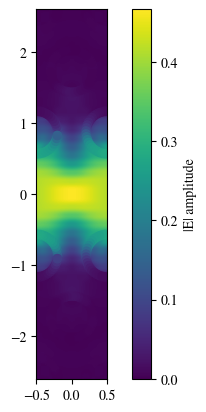

In [8]:
borders,phis,radii = hole_borders(phc,phidiv=45)

#now the field at the edges of the holesE
EHoles = get_xyfield(gme,0,14,borders,phc.layers[0].d/2,field='E',components='xyz')

#now get the fild across the whole phc
E,_,_ = gme.get_field_xy('E',0,14,phc.layers[0].d/2)

Eamp = np.sqrt(np.abs(E['x'])**2 + np.abs(E['y'])**2 + np.abs(E['z'])**2)
EHolesamp = np.sqrt(np.abs(EHoles['x'])**2 + np.abs(EHoles['y'])**2 + np.abs(EHoles['z'])**2)
norm = plt.Normalize(vmin=0, vmax=np.max(Eamp))
cmap = plt.cm.viridis

plt.imshow(Eamp,cmap=cmap,norm=norm,extent=[-.5,.5,-np.sqrt(3)/2*7,np.sqrt(3)/2*7])
sc = plt.scatter(borders[:,:,0], borders[:,:,1], c=EHolesamp[:], cmap=cmap, norm=norm)
plt.colorbar(sc, label='|E| amplitude')
plt.ylim(-np.sqrt(3)/2*3,np.sqrt(3)/2*3)
plt.show()

Now we will calculate the polorizability tensors

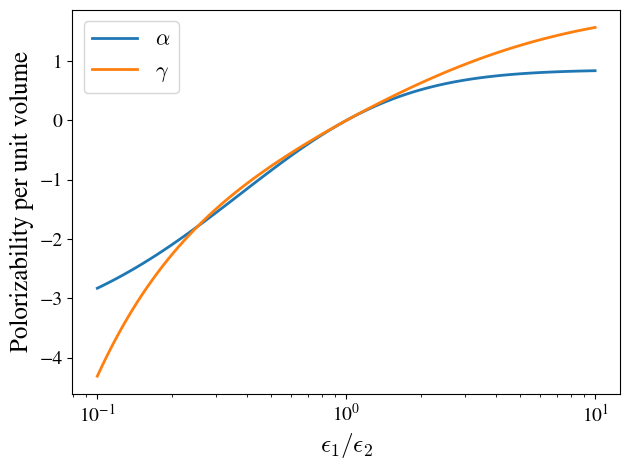

In [9]:
def polyTensorCylin(eps1, eps2):
    """
    Compute parallel and perpendicular polarizability tensor components
    for a cylinder with dielectric constant eps1 in background eps2.
    """
    # Fitted parameters for the model
    alpha_inf = 0.8510
    alpha_0 = 3.882
    alpha_inf_prime = 3.905
    alpha_0_prime = 0.7669

    tau = eps1 / eps2

    # Parallel component
    alpha = 2 * (tau - 1) / (tau + 1) * (
        1 + (tau - 1) / (tau / (alpha_inf / 2 - 1) - 1 / (alpha_0 / 2 - 1))
    )
    # Perpendicular component
    gamma = (tau - 1) / tau * (
        1 + (tau - 1) / (tau / (alpha_inf_prime / 2 - 1) - 1 / (alpha_0_prime / 2 - 1))
    )
    return alpha, gamma

eps1s = np.logspace(-1,1,100)
eps2s = 1

plt.plot(eps1s/eps2s, polyTensorCylin(eps1s,eps2s)[0], label=r'$\alpha$', linewidth=2)
plt.plot(eps1s/eps2s, polyTensorCylin(eps1s,eps2s)[1], label=r'$\gamma$', linewidth=2)
plt.xscale('log')
plt.xlabel(r'$\epsilon_1/\epsilon_2$', fontsize=18)
plt.ylabel('Polorizability per unit volume', fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

Now we want to calculate the bump purturbation polorizability model: $$P(r)=\left[\varepsilon_{avg}\alpha_{||}E_{||}(r)+\varepsilon(r)\gamma_{\perp}D_{\perp}(r))\right]\Delta V$$

What we really care about is $\mathbb{E}[P(r)]$ since that is what our expectation value for the frequecy shift is based on. In the end it comes down to $$\mathbb{E}[P(r)]=\left(\varepsilon_{avg}\mathbb{E}[\alpha_{||}\Delta A]E_{||}(r)+\varepsilon(r)\mathbb{E}[\gamma_{\perp}\Delta A]D_{\perp}(r)\right)h$$ 

Now $\Delta A$ is proportional to the shift of the circle, $\delta r$. So if $\Delta r\sim |\mathcal{N}(0,\sigma)|$ and $\alpha \sim\mathcal{U}[\alpha^-,\alpha^+]$ and $\gamma \sim\mathcal{U}[\gamma^-,\gamma^+]$. These probability distributions are independent and give us a final expectation value of $$\mathbb{E}[\Delta r\alpha]=\mathbb{E}[\Delta r]\mathbb{E}[\alpha]=\sigma\sqrt{\frac{2}{\pi}}\frac{\alpha^-+\alpha^+}{2}$$ and $$\mathbb{E}[\Delta r\gamma]=\mathbb{E}[\Delta r]\mathbb{E}[\gamma]=\sigma\sqrt{\frac{2}{\pi}}\frac{\gamma^-+\gamma^+}{2}$$

This give the final expression of $$\mathbb{E}[P(r)]=\sigma\sqrt{\frac{2}{\pi}}\left(\varepsilon_{avg}\frac{\alpha_{||}^-+\alpha_{||}^+}{2}E_{||}(r)+\varepsilon(r)\frac{\gamma_\perp^-+\gamma_\perp^+}{2}D_{\perp}(r)\right)h$$


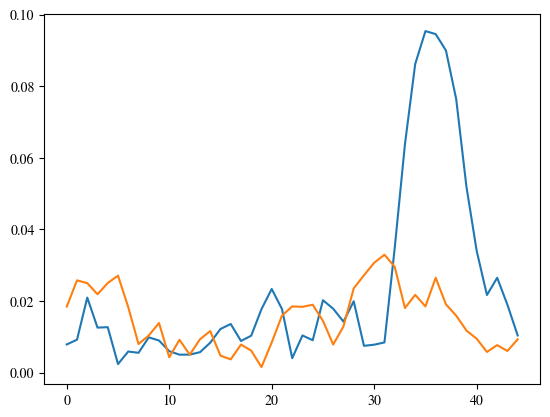

In [10]:
def bumpPurityModel(phc,gme,k,sigma,z):
    borders,phis,radii = hole_borders(phc,phidiv=45)

    #now the field at the edges of the holesE (we ignore z since it is 0)
    EHoles = get_xyfield(gme,k,14,borders,z,field='E',components='xy')
    DHoles = get_xyfield(gme,k,14,borders,z,field='D',components='xy')

    #get the perpendicular and parallel components of the field
    Epara = np.array([-np.sin(phis)*EHoles['x'],np.cos(phis)*EHoles['y']])
    Dperp = np.array([np.cos(phis)*DHoles['x'],np.sin(phis)*DHoles['y']])

    #get the polorizability tensors
    alphaPlus, gammaPlus = polyTensorCylin(phc.layers[0].eps_b,1)
    alphaNeg, gammaNeg = polyTensorCylin(1,phc.layers[0].eps_b)
    avgAlpha = (alphaPlus+alphaNeg)/2
    avgGamma = (gammaPlus+gammaNeg)/2

    #get epsilon average and height
    avgEps = (phc.layers[0].eps_b+1)/2
    h = phc.layers[0].d

    #get the bump purturbation model
    p = sigma*np.sqrt(2/np.pi)*(avgEps * avgAlpha * Epara + 1 * avgGamma * Dperp) * h
    
    return(p)

#get the bump purturbation model
p = bumpPurityModel(phc,gme,0,1,phc.layers[0].d/2)

plt.plot(np.abs(p[:,8,:].T))
plt.show()

In [11]:
def frequencyShift(phc,gme,k,sigma,Nz=5,phidiv=45):
    borders,phis,radii = hole_borders(phc,phidiv=phidiv)

    out = 0
    for z in np.linspace(0,phc.layers[0].d,Nz,endpoint=True):
        #We need to get the Efield and the polorizability model
        EHoles = get_xyfield(gme,k,14,borders,z,field='E',components='xy')
        p = bumpPurityModel(phc,gme,k,sigma,z)

        itegrand = np.conj(EHoles['x'])*p[0]+np.conj(EHoles['y'])*p[1]

        out += -gme.freqs[k,14]/2*np.sum(itegrand*radii[:,np.newaxis])*np.pi*2/phidiv*phc.layers[0].d/Nz
    return(out)

sigmas = [0,0.025,0.05]
ks = npa.linspace(.5*np.pi,np.pi,5)
phc = optomization.W1(NyChange=0,Ny=7)
gme = legume.GuidedModeExp(phc,4.01)
gme.run(gmode_inds=[0],numeig=21,compute_im=False,verbose=False,kpoints=npa.array([ks,[0]*len(ks)]))


freq_shifts = []
for k in range(len(ks)):
    freq_shifts.append([])
    for sigma in sigmas:
        freq_shifts[k].append(np.abs(frequencyShift(phc,gme,k,sigma*a)))



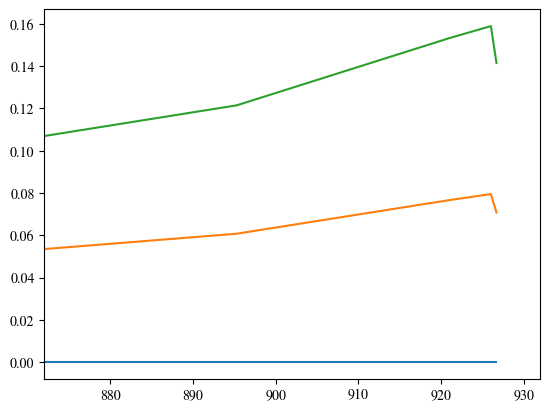

In [12]:
plt.plot(a/gme.freqs[:,14],np.array(freq_shifts)/gme.freqs[:,14][:,np.newaxis]**2)
plt.xlim(872,932)
plt.show()

# Compare computed shift to GME shift 

We are going to run this and do one hole shift. only shift the hole directly above the gap in the y direction

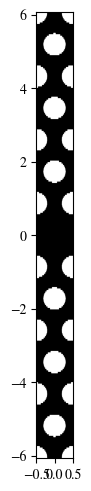

In [103]:
#first we need to define a new function for the W1 that shift the holes in different directions
def W1_shifted(NyChange=3,Ny=7,dslab=170/266,eps_slab=3.4638,ra=.3,y_shift=0):

    phc = optomization.W1(NyChange=0,Ny=Ny,dslab=dslab,eps_slab=eps_slab,ra=ra)
    for i,circle in enumerate(phc.layers[0].shapes):
        if i == 6:
            circle.y_cent += y_shift
    return(phc)

phc = W1_shifted(y_shift=0)
_ = legume.viz.eps_xy(phc,Nx=300,Ny=300)


In [104]:
y_shifts = np.linspace(-0.04,0.04,11)
freqs = []
ks = [0.75*np.pi]
for y_shift in y_shifts:
    phc = W1_shifted(y_shift=y_shift)
    gme = legume.GuidedModeExp(phc,4.01)
    gme.run(gmode_inds=[0],numeig=21,compute_im=False,verbose=False,kpoints=npa.array([ks,[0]*len(ks)]))
    freqs.append(gme.freqs[:,14])

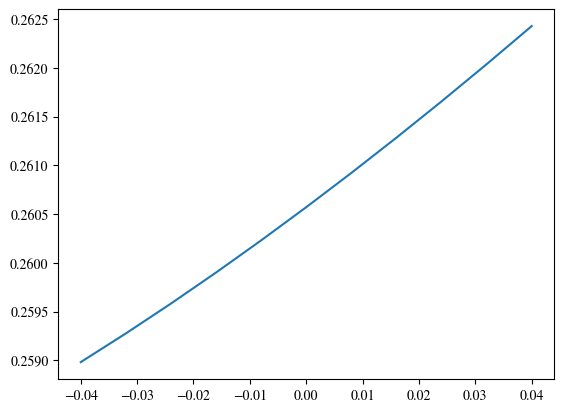

In [105]:
plt.plot(y_shifts, freqs)
plt.show()

In [106]:
phc = W1_shifted(y_shift=0)
gme = legume.GuidedModeExp(phc,4.01)
gme.run(gmode_inds=[0],numeig=21,compute_im=False,verbose=False,kpoints=npa.array([ks,[0]*len(ks)]))

In [153]:
def calcShift(gme,
        k=0,
        n=120,
        xys=[],
        zs=[],
        phis=[],
        x_shift=0,
        y_shift=0
        ):

    #get the epilon values
    eps1 = 1                         #vacuum
    eps2 = gme.phc.layers[0].eps_b   #material

    #get the shift and normal vectors
    s = np.array([[x_shift,y_shift] for _ in phis])
    normal = np.array([[np.cos(f),np.sin(f)] for f in phis])
    sdn = np.sum(s * normal, axis=1)

    integral = 0
    for i in range(len(zs)):
        #get the electric fields
        Es = get_xyfield(gme,k,n,xys,zs[i],field='E',components='xy')
        Ds = get_xyfield(gme,k,n,xys,zs[i],field='D',components='xy')
        
        #get the perpendicular and parallel components of the dispacement and electric field, respectively
        E = np.array([Es['x'],Es['y']])[:,0,:]
        Epara = np.array([np.sin(phis)*Es['x'],np.cos(phis)*Es['y']])[:,0,:]
        Dperp = np.array([np.cos(phis)*Ds['x'],np.sin(phis)*Ds['y']])[:,0,:]

        #get the bump purturbation model
        alphaPlus, gammaPlus = polyTensorCylin(phc.layers[0].eps_b,1)
        alphaNeg, gammaNeg = polyTensorCylin(1,phc.layers[0].eps_b)
        alpha_array = np.zeros_like(Epara)
        alpha_array[:,:45//2] = alphaPlus
        alpha_array[:,45//2:] = alphaNeg
        gamma_array = np.zeros_like(Dperp)
        gamma_array[:,:45//2] = gammaPlus
        gamma_array[:,45//2:] = gammaNeg
        p = ((eps1-eps2)/2 * alpha_array * Epara + eps1 * gamma_array * Dperp)

        #calculate the integrand
        integrand = np.sum(np.conj(E) * p ,axis=0) * sdn
        
        integral += np.sum(integrand)
    
    #integration constant 
    const = 0.3 * (phc.layers[0].d/len(zs))* (2*np.pi/len(phis))

    integral = -(gme.freqs[0,14])/2*integral*const
    
    return(integral)

zs_original = np.linspace(0,phc.layers[0].d,12,endpoint=True)
zs_midpoints = zs_original[:-1] + (zs_original[1:] - zs_original[:-1])/2
borders,phis,radii = hole_borders(phc,phidiv=45)
integrals6 = []
integrals7 = []
for y_shift in y_shifts:
    integrals6.append(calcShift(gme,k=0,n=14,xys=borders[6][np.newaxis,:,:],zs=zs_midpoints,phis=phis,y_shift=y_shift))
    integrals7.append(calcShift(gme,k=0,n=14,xys=borders[7][np.newaxis,:,:],zs=zs_midpoints,phis=phis,y_shift=y_shift))

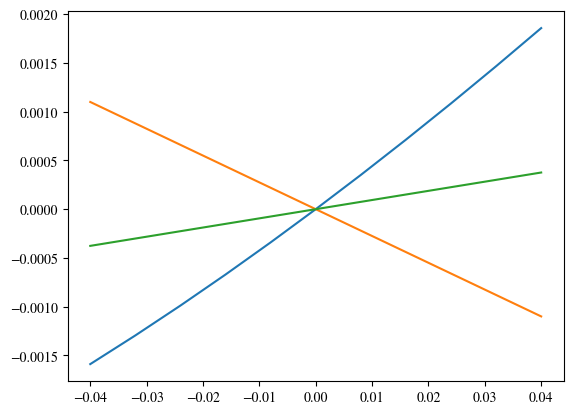

In [154]:
plt.plot(y_shifts, np.real(freqs)-freqs[5])
plt.plot(y_shifts, np.real(integrals7))
plt.plot(y_shifts, np.real(integrals6))
plt.show()

In [139]:
s = np.array([[0,0.01] for _ in phis])
normal = np.array([[np.cos(f),np.sin(f)] for f in phis])
sdn = np.sum(s * normal, axis=1)
sdn.shape


(45,)

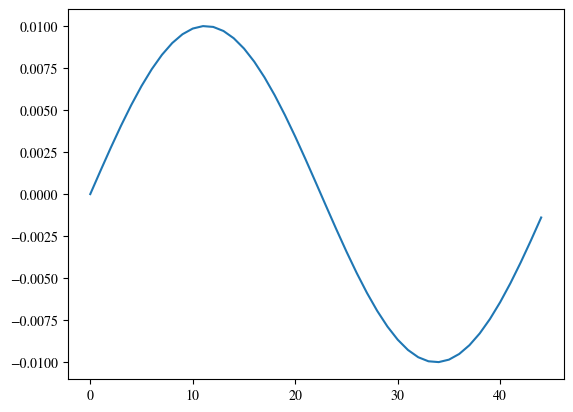

In [140]:
plt.plot(sdn)